# Classification & Visualisation

In [1]:
import warnings 
warnings.filterwarnings("ignore", category=RuntimeWarning)


import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

import sys
sys.path.append("../scripts/")

# librairies perso
from import_data import import_data
from metrics import metrics, tab_mesure 
from group_by_clients import group_by_clients
from creation_model import complet_process
from display import display_mesure
from metrics import export_mesure, permutation_feature_importance

In [2]:
data = import_data()

def set_up_index(index): 
    index.rename({"Date": "horodate"}, axis = 1, inplace = True)
    index["horodate"] = pd.to_datetime(index["horodate"])
    index.set_index("horodate", inplace = True)
    index = index.asfreq("D")
    index.reset_index(inplace = True)
    index = index.fillna(method = "ffill")
    date = (index["horodate"] >= pd.to_datetime("2021-01-01")) & (index["horodate"] <= pd.to_datetime("2023-01-31"))
    index = index[date]
    index.reset_index(inplace = True)
    index = index[["horodate", "Open"]]
    return index 

CAC = pd.read_csv("../data/^FCHI.csv")
AEX = pd.read_csv("../data/^AEX.csv")
BFX = pd.read_csv("../data/^BFX.csv")
STOXX = pd.read_csv("../data/^STOXX50E.csv")
Airliquide = pd.read_csv("../data/AI.PA.csv")
gasNat = pd.read_csv("../data/gasNat.csv").rename({"Ouvert": "Open"}, axis = 1)

CAC = set_up_index(CAC)
AEX = set_up_index(AEX)
BFX = set_up_index(BFX)
STOXX = set_up_index(STOXX)
Airliquide = set_up_index(Airliquide)
gasNat = set_up_index(gasNat)

CAC.rename({"Open": "CAC"}, axis = 1, inplace = True)
AEX.rename({"Open": "AEX"}, axis = 1, inplace = True)
BFX.rename({"Open": "BFX"}, axis = 1, inplace = True)
STOXX.rename({"Open": "STOXX"}, axis = 1, inplace = True)
Airliquide.rename({"Open": "Airliquide"}, axis = 1, inplace = True)
gasNat.rename({"Open": "gasNat"}, axis = 1, inplace = True)

#CAC.rename({"Volume": "CAC"}, axis = 1, inplace = True)
#AEX.rename({"Volume": "AEX"}, axis = 1, inplace = True)
#BFX.rename({"Volume": "BFX"}, axis = 1, inplace = True)
#STOXX.rename({"Volume": "STOXX"}, axis = 1, inplace = True)

# il faut merge avec le tableau principal
data = pd.merge(data, CAC, on = ["horodate"], how = "left")
data = pd.merge(data, AEX, on = ["horodate"], how = "left")
data = pd.merge(data, BFX, on = ["horodate"], how = "left")
data = pd.merge(data, STOXX, on = ["horodate"], how = "left")
data = pd.merge(data, Airliquide, on = ["horodate"], how = "left")
data = pd.merge(data, gasNat, on = ["horodate"], how = "left")
n = data["id_client"].max()
test_data = data[data["horodate"] > pd.to_datetime("2022-08-31")]

data = data[~(data["id_client"].isin([8,9, 17, 23, 28, 37, 38 , 49]))]

## Visualisation

In [3]:
def plot_client(df, client):
    df.groupby("id_client").get_group(df["id_client"].unique()[client]).plot(x = "horodate", y = ["real_consumption", "forecasted_consumption"])

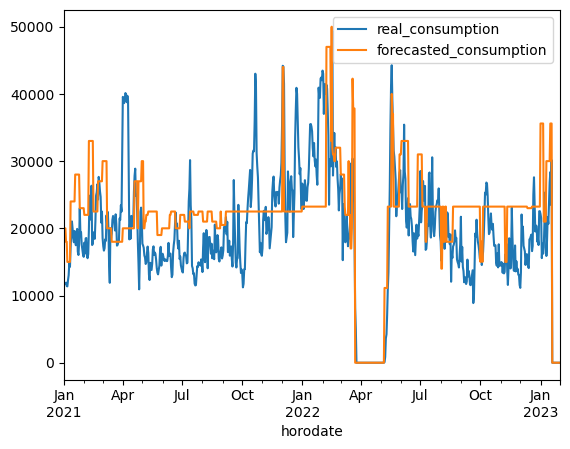

In [4]:
plot_client(data, 1)

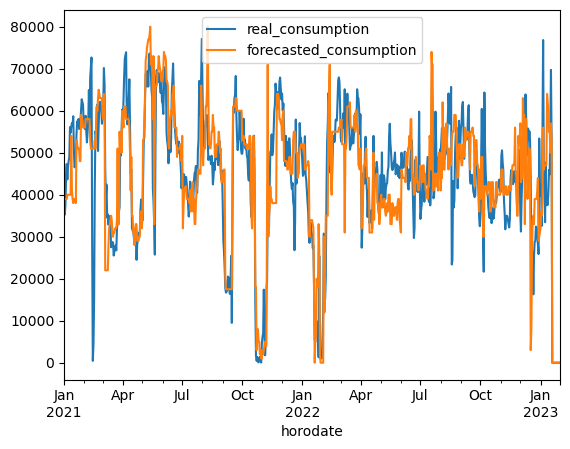

In [5]:
plot_client(data, 5)

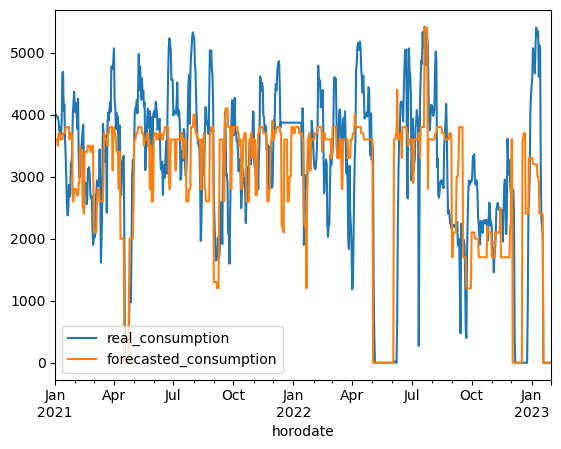

In [6]:
plot_client(data, 18)

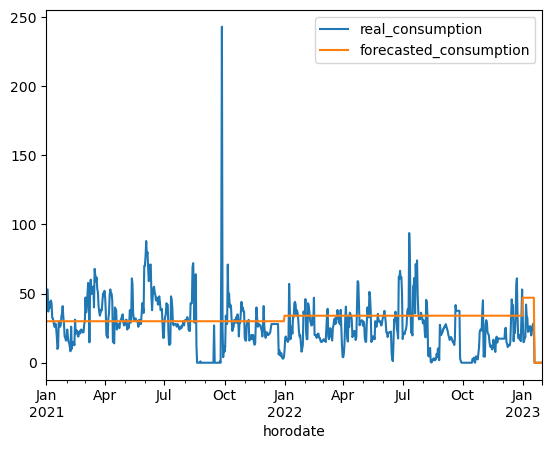

In [7]:
plot_client(data, 23)

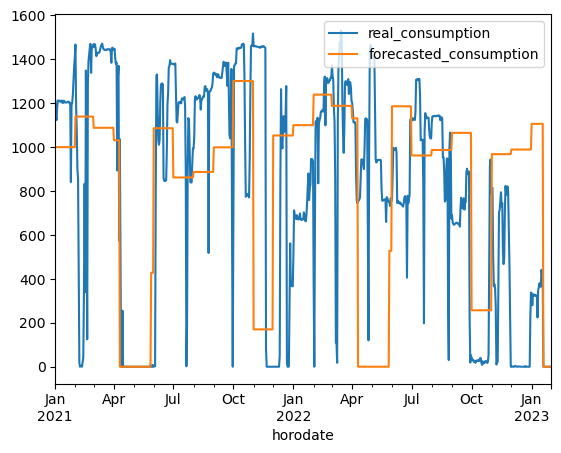

In [8]:
plot_client(data, 27)

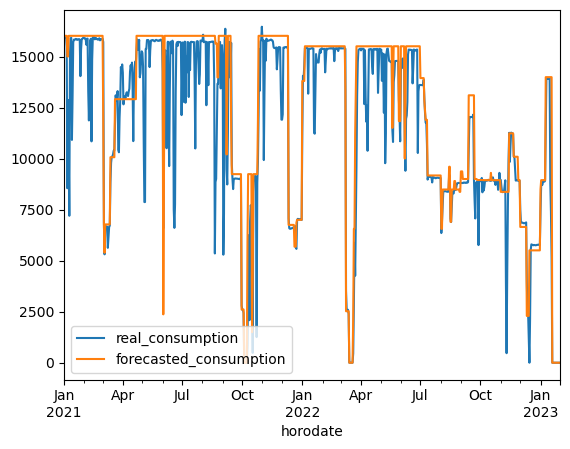

In [9]:
plot_client(data, 32)

## Corrélation

<Axes: >

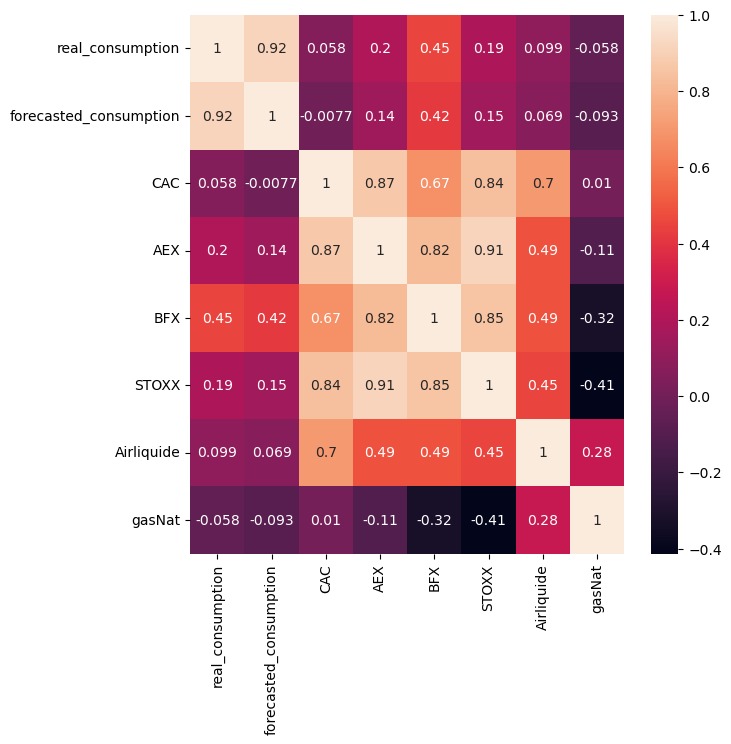

In [36]:
plt.figure(figsize = (7,7))
sns.heatmap(data.groupby("id_client").get_group(1).drop(["id_client", "prediction", "horodate"], axis = 1).corr(), annot = True)

<Axes: >

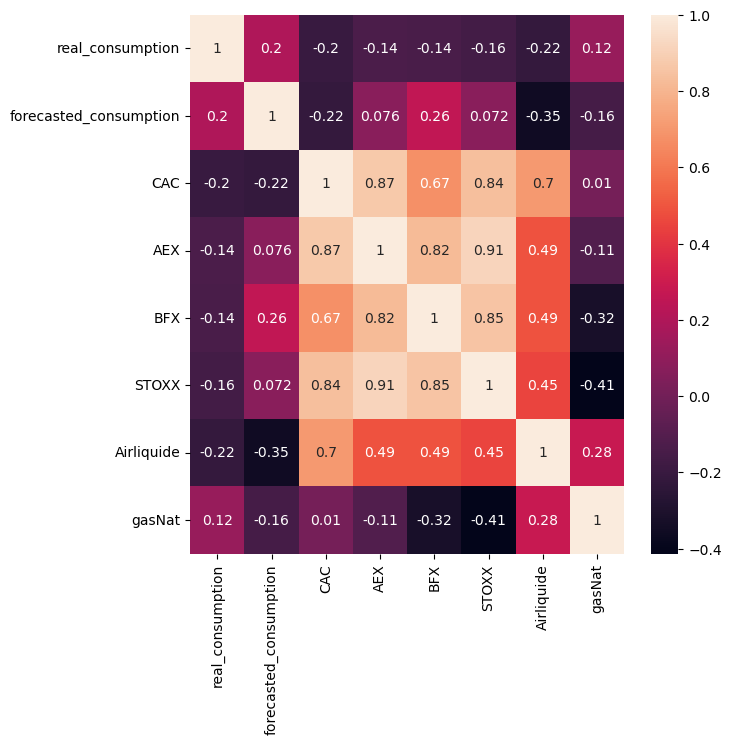

In [37]:
plt.figure(figsize = (7,7))
sns.heatmap(data.groupby("id_client").get_group(5).drop(["id_client", "prediction", "horodate"], axis = 1).corr(), annot = True)

<Axes: >

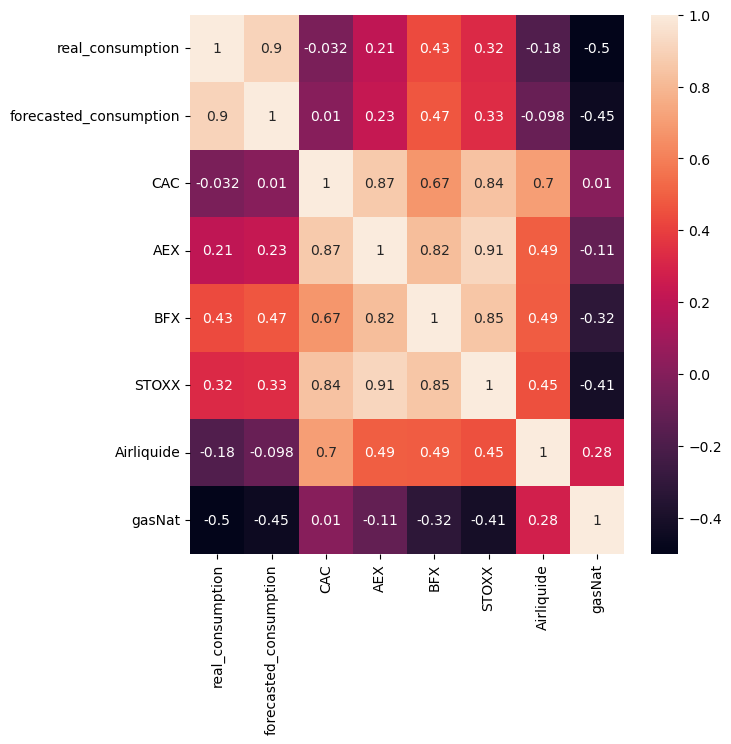

In [39]:
plt.figure(figsize = (7,7))
sns.heatmap(data.groupby("id_client").get_group(10).drop(["id_client", "prediction", "horodate"], axis = 1).corr(), annot = True)

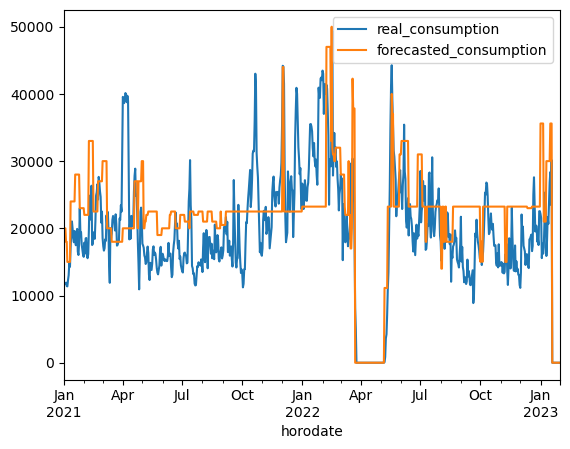

In [41]:
plot_client(data, 1)

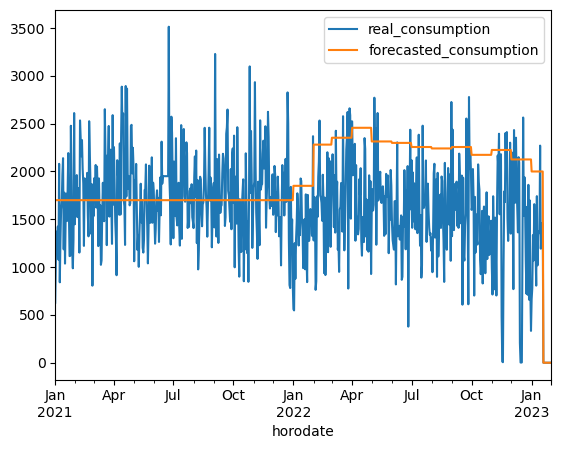

In [42]:
plot_client(data, 10)

## Classification sur les consommations réelles

In [15]:
timeSeries = np.array(data[data["id_client"] == 1]["real_consumption"])
for i in data["id_client"].unique():
    tab = data[data["id_client"] == i]["real_consumption"]
    if len(tab) != 761:
        tab = np.hstack((tab , [0]))
    timeSeries = np.vstack((timeSeries, tab))

In [43]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 3. Normalisation des données
#scaler = StandardScaler()
#normalized_data = scaler.fit_transform(timeSeries)

# 4. Choix de l'algorithme de clustering
kmeans = KMeans(n_clusters=8)

# 5. Application du clustering
kmeans.fit(timeSeries)

# Obtenez les étiquettes de cluster pour chaque échantillon
labels = kmeans.labels_

/opt/miniconda3/envs/data/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [44]:
labels

array([6, 6, 7, 4, 2, 0, 1, 3, 5, 0, 0, 0, 0, 0, 6, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 2, 0, 0, 6, 0, 2, 6, 0, 6],
      dtype=int32)

In [45]:
time = data[data["id_client"] == 1]["horodate"]

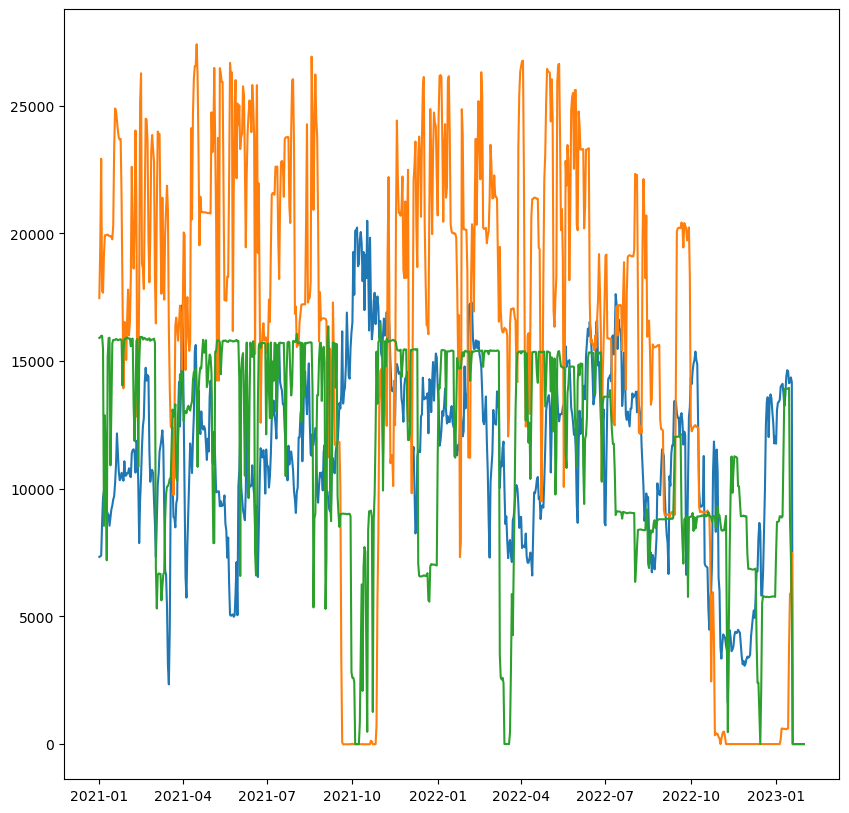

In [92]:
plt.figure(figsize =(10,10))
count = 3
j=0
for i in range(len(data["id_client"].unique())):
    if labels[i] == 2 and j < count: 
        j+=1
        plt.plot(time, timeSeries[i,:])

## Classification sur les consommations réelles

In [93]:
timeSeries = np.array(data[data["id_client"] == 1]["forecasted_consumption"])
for i in data["id_client"].unique():
    tab = data[data["id_client"] == i]["forecasted_consumption"]
    if len(tab) != 761:
        tab = np.hstack((tab , [0]))
    timeSeries = np.vstack((timeSeries, tab))

In [98]:
# 3. Normalisation des données
#scaler = StandardScaler()
#normalized_data = scaler.fit_transform(timeSeries)

# 4. Choix de l'algorithme de clustering
kmeans = KMeans(n_clusters=15)

# 5. Application du clustering
kmeans.fit(timeSeries)

# Obtenez les étiquettes de cluster pour chaque échantillon
labels = kmeans.labels_

/opt/miniconda3/envs/data/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [99]:
labels

array([ 7,  7,  6,  1, 11,  0,  5,  3,  4,  0,  0, 13,  0,  0, 14,  8,  0,
       13, 13,  9,  0,  0,  0,  0,  0, 13, 13,  0, 13,  0,  0, 13, 14,  2,
       13, 13, 12,  9, 10, 14,  9,  0], dtype=int32)

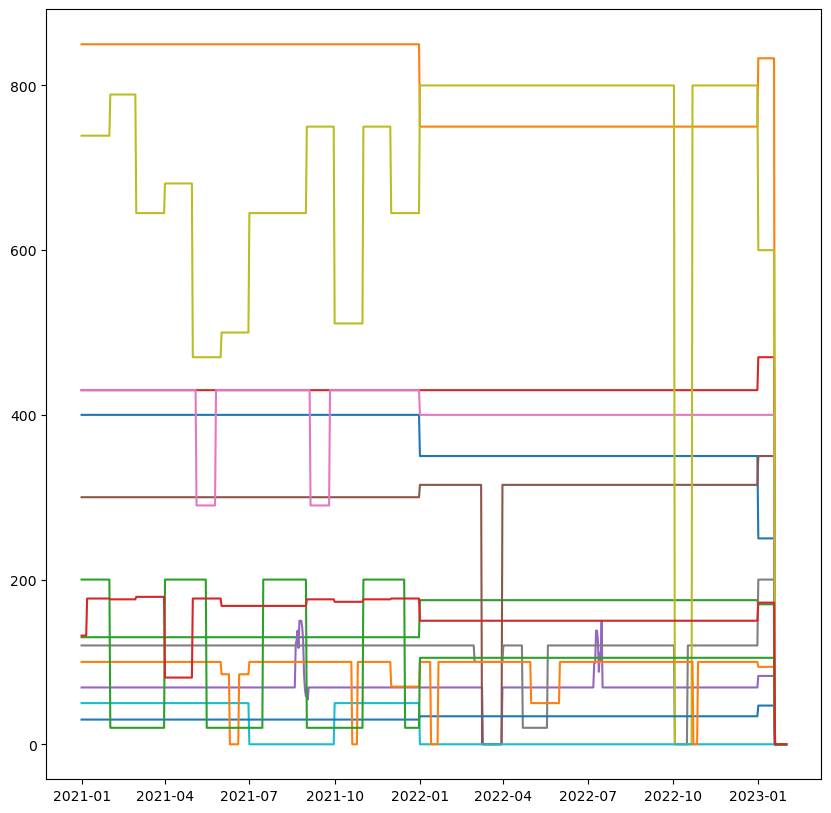

In [102]:
plt.figure(figsize =(10,10))
for i in range(len(data["id_client"].unique())):
    if labels[i] == 0: 
        plt.plot(time, timeSeries[i,:])